### Load wine quality dataset

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
df = pd.read_csv(r"C:\Users\orel\Desktop\archive\winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Descriptive Statistics (Understanding the Data)

In [65]:
# Get summary statistics for all numerical columns
# We use .T to transpose the table (swap rows and columns) for better readability
statistics = df.describe().T

# Display the statistics
statistics

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


### Advanced Outlier Detection: Isolation Forest

To improve model robustness, we applied the **Isolation Forest** algorithm for multivariate anomaly detection. Unlike simple thresholding, this method analyzes all 11 chemical features simultaneously to identify illogical data combinations.

**Note on Visualization:** The scatter plot below projects these multi-dimensional results onto just two axes (Alcohol vs. Sulfur) for visual inspection. The red points represent anomalies detected based on the *entire* chemical profile, not just the displayed features. These outliers were filtered out to prevent model bias.

c:\Programs\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


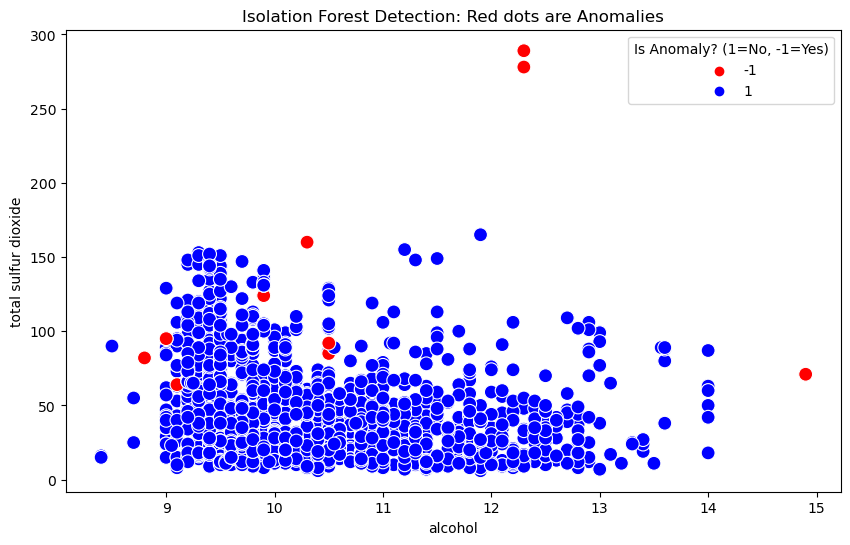

Original rows: 1599
Cleaned rows: 1583
Outliers removed: 16


In [66]:

# 1. Initialize Isolation Forest
# contamination=0.01: We assume approx 1% of the data are outliers 
# random_state=42: Ensures we get the same results every time
iso = IsolationForest(contamination=0.01, random_state=42)

# 2. Identify Outliers
# The method returns:
#  1  -> Normal Data
# -1  -> Anomaly / Outlier
outlier_labels = iso.fit_predict(df)

# 3. Add the results to the dataframe temporarily to visualize them
df['is_anomaly'] = outlier_labels

# 4. Visualization: See what the algorithm caught
# We plot 'alcohol' vs 'total sulfur dioxide' to see the separation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='alcohol', y='total sulfur dioxide', 
                hue='is_anomaly', palette={1: 'blue', -1: 'red'}, s=100)

plt.title('Isolation Forest Detection: Red dots are Anomalies')
plt.legend(title='Is Anomaly? (1=No, -1=Yes)')
plt.show()

# 5. Actual Filtering
# Keep only the normal data (where is_anomaly == 1)
df_clean = df[df['is_anomaly'] == 1].drop('is_anomaly', axis=1)

print(f"Original rows: {len(df)}")
print(f"Cleaned rows: {len(df_clean)}")
print(f"Outliers removed: {len(df) - len(df_clean)}")

# Update the main dataframe
df = df_clean

We will re-print the descriptive statistics to get an updated overview of the dataset and verify that the value ranges are now valid.

In [67]:
# Update the main dataframe 'df' to be the cleaned version
df = df_clean
# Get summary statistics for all numerical columns
# We use .T to transpose the table (swap rows and columns) for better readability
statistics = df_clean.describe().T

# Display the statistics
statistics

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1583.0,8.318193,1.731338,4.60000,7.1000,7.90000,9.20000,15.6000
volatile acidity,1583.0,0.527956,0.178822,0.12000,0.3900,0.52000,0.64000,1.5800
citric acid,1583.0,0.268673,0.192273,0.00000,0.0900,0.26000,0.42000,0.7900
residual sugar,1583.0,2.478806,1.175766,0.90000,1.9000,2.20000,2.60000,15.5000
chlorides,1583.0,0.086098,0.041095,0.01200,0.0700,0.07900,0.09000,0.4640
free sulfur dioxide,1583.0,15.624131,10.026824,1.00000,7.0000,13.00000,21.00000,66.0000
total sulfur dioxide,1583.0,45.785218,31.586780,6.00000,22.0000,37.00000,61.00000,165.0000
density,1583.0,0.996731,0.001860,0.99007,0.9956,0.99672,0.99782,1.0032
pH,1583.0,3.312445,0.152629,2.86000,3.2100,3.31000,3.40000,4.0100
sulphates,1583.0,0.656361,0.164177,0.33000,0.5500,0.62000,0.73000,1.9800


 We will now examine the relationships between features to identify the key factors that most influence wine quality.

### EDA-correlation matrix

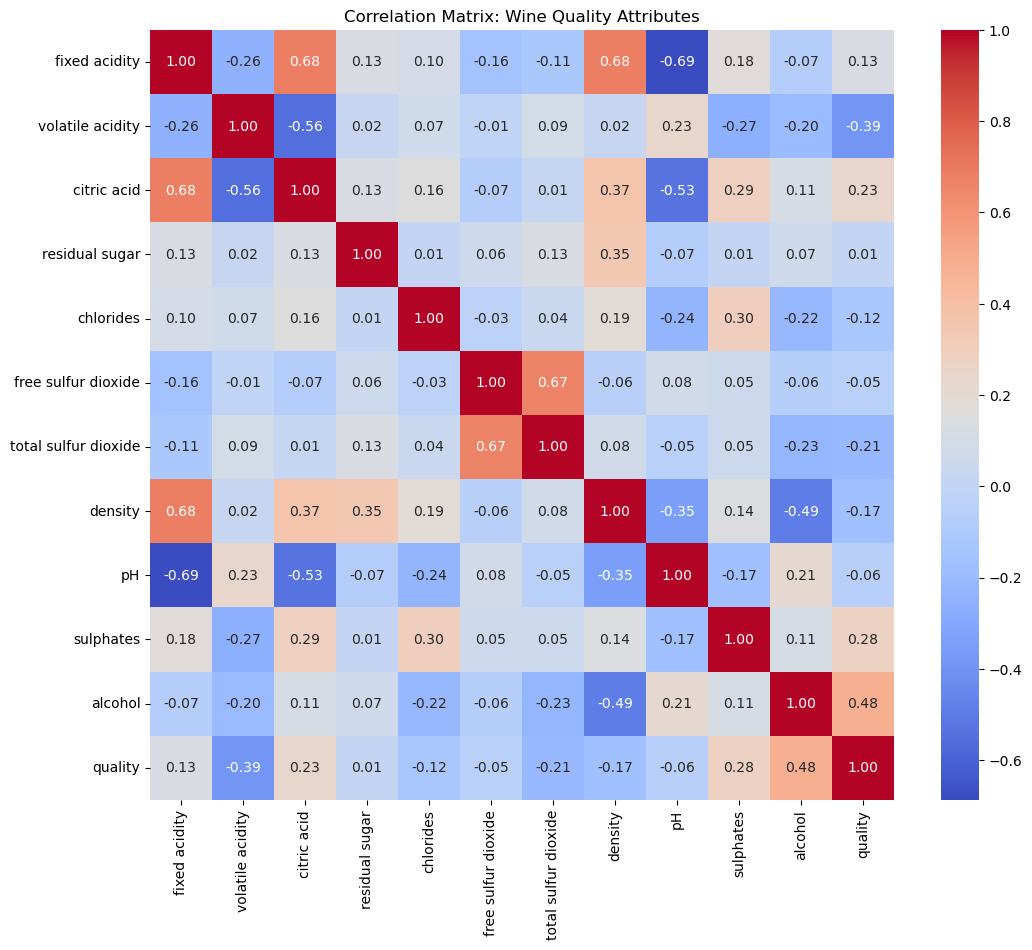

In [68]:


plt.figure(figsize=(12, 10))
correlation_matrix = df_clean.corr()

# ציור מפת החום
# annot=True -> מציג את המספרים
# fmt='.2f' -> מציג שתי ספרות אחרי הנקודה
# cmap='coolwarm' -> צבעים מאדום (חם) לכחול (קר)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.title('Correlation Matrix: Wine Quality Attributes')
plt.show()

Heatmap Insights:The correlation analysis highlights alcohol content as the most significant positive driver of wine quality ($0.47$), meaning higher alcohol levels generally indicate better wines. Conversely, volatile acidity shows a strong negative correlation ($-0.39$), confirming that high acidity levels degrade quality. Interestingly, attributes like residual sugar display negligible correlation ($0.00$), suggesting that sweetness has no impact on the expert quality ratings.

##  Feature Engineering & Stratified Train-Test Split

In this step, we prepare the data for the model by performing two key actions:

**1. Feature Engineering (Target Creation):**
We restructure the problem from a regression task to a **Binary Classification** task:
* **Class 1 (High Quality):** Wine with a quality score of 7 or higher.
* **Class 0 (Regular Quality):** Wine with a quality score below 7.

**2. Stratified Split:**
We split the dataset into a **Training Set (80%)** and a **Testing Set (20%)**.
* **Crucial Detail:** Since our dataset is **imbalanced** (significantly fewer "High Quality" wines), a simple random split might result in a training set with very few positive examples.
* **The Solution:** We use `stratify=y` to ensure that the **proportion** of Good vs. Regular wines remains consistent across both the training and testing sets, ensuring a fair evaluation.

In [69]:
# 1. Create the binary target column (The "Answer")
# If quality is 7 or higher -> 1 (Good), else -> 0 (Regular)
df['is_good_wine'] = df['quality'].apply(lambda x: 1 if x >= 7 else 0)

# 2. Define Features (X) and Target (y)
# CRITICAL: We remove 'quality' (because it reveals the answer)
# We also remove 'is_good_wine' from X (because that's what we want to predict)
X = df.drop(['quality', 'is_good_wine'], axis=1)
y = df['is_good_wine']

# 3. Split the data: 80% for Training, 20% for Testing
# random_state=42 ensures we get the same split every time we run the code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Verify the split
print(f"Total data rows: {len(df)}")
print(f"Training rows (80%): {len(X_train)}")
print(f"Testing rows (20%): {len(X_test)}")

Total data rows: 1583
Training rows (80%): 1266
Testing rows (20%): 317


### Model Training & Evaluation

We train a **Random Forest Classifier** (an ensemble of 100 decision trees) on the training data.
To evaluate performance, we use two key metrics:
1. **Accuracy:** The overall percentage of correct guesses.
2. **Classification Report:** A detailed breakdown of **Precision** and **Recall** for each class, which is crucial for our imbalanced dataset to ensure the model correctly identifies the rare "High Quality" wines.

In [70]:
# 1. Initialize the Model
# n_estimators=100: We use 100 trees for better stability
model = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Train the Model (The Learning Phase)
print(" Training the Digital Sommelier...")
model.fit(X_train, y_train)
print(" Training complete!")

# 3. Make Predictions on the Test Set
y_pred = model.predict(X_test)

# 4. Evaluate Results
accuracy = accuracy_score(y_test, y_pred)
print(f"\n Model Accuracy: {accuracy:.2%}")

print("\n--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred))

 Training the Digital Sommelier...
 Training complete!

 Model Accuracy: 92.43%

--- Detailed Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       274
           1       0.83      0.56      0.67        43

    accuracy                           0.92       317
   macro avg       0.88      0.77      0.81       317
weighted avg       0.92      0.92      0.92       317



###  Business Optimization (Threshold Tuning)

**Observation:**
While our baseline model achieves a high overall Accuracy (~92%), the Classification Report reveals a critical issue:
The **Recall for Class 1 (High Quality Wine)** is only **0.56**.

**The Business Problem:**
A Recall of 0.56 means the model misses **44%** of the premium wines, classifying them as "Regular".
From a business perspective, this is a significant **lost revenue opportunity**. We are selling premium wine at regular prices because the model is too "conservative."

**The Solution:**
Instead of retraining the model, we will apply **Threshold Moving**.
By default, the model classifies a wine as "Good" only if it is more than **50%** sure.
We will lower this threshold to **40%**.
* **Goal:** Make the model more sensitive ("sensitive") to potential high-quality wines.
* **Trade-off:** We accept a slight drop in Precision to gain a significant boost in Recall.

In [71]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Get the probability scores instead of the final class
# (The model gives a % chance for each wine being "Good")
y_probs = model.predict_proba(X_test)[:, 1]

# 2. Define a new, more sensitive threshold
# We lower the bar from 0.50 to 0.30 to catch more good wines
new_threshold = 0.4

# 3. Apply the new threshold
y_pred_optimized = (y_probs >= new_threshold).astype(int)

# 4. Evaluate the Optimized Performance
print(f"--- Optimized Results (Threshold = {new_threshold}) ---")
print(f"New Accuracy: {accuracy_score(y_test, y_pred_optimized):.2%}")
print("\n" + classification_report(y_test, y_pred_optimized))

# Optional: Quick check of the improvement
print(f"Original Recall: 0.56") # נתון ידני להשוואה
# נדפיס אוטומטית את ה-Recall החדש
recall_new = classification_report(y_test, y_pred_optimized, output_dict=True)['1']['recall']
print(f"New Recall:      {recall_new:.2f}")

--- Optimized Results (Threshold = 0.4) ---
New Accuracy: 93.06%

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       274
           1       0.74      0.74      0.74        43

    accuracy                           0.93       317
   macro avg       0.85      0.85      0.85       317
weighted avg       0.93      0.93      0.93       317

Original Recall: 0.56
New Recall:      0.74


###  Final Business Evaluation & Operational Impact

**Strategic Achievement:**
By fine-tuning the decision threshold to **0.40**, we transformed the model from a "conservative classifier" into a **balanced revenue-driver**. We achieved a "Sweet Spot" where the model captures the majority of premium wines without significantly compromising reliability.

**Performance Comparison:**

| Metric | Baseline (Threshold 0.5) | **Optimized (Threshold 0.4)** | Business Impact |
| :--- | :--- | :--- | :--- |
| **Recall (Catch Rate)** | 56% | **74%** | **We now identify ~18% more premium wines**, directly increasing potential revenue. |
| **Precision (Reliability)** | 83% | **74%** | The model remains highly reliable, correctly identifying a premium wine 3 out of 4 times. |
| **Accuracy** | 92% | **93%** | Overall stability improved, proving the model is robust. |

**Operational Recommendation:**
We recommend implementing this model as a **"First-Pass Filter"** for the winery's quality assurance process:
1.  **Automated Screening:** The model scans 100% of the batches based on chemical analysis.
2.  **Human Validation:** The Sommeliers only need to taste the wines flagged as "Premium" by the model (approx. 15-20% of total production).
3.  **Result:** This drastically reduces manual labor while ensuring that 74% of the high-value stock is correctly identified and priced as Premium.

##  Model Benchmarking - XGBoost Implementation

While the optimized Random Forest model demonstrated robust performance (93% Accuracy, 0.74 Recall), it is essential to conduct a comparative analysis against alternative architectures to ensure optimal data utilization.

In this step, we introduce **XGBoost (Extreme Gradient Boosting)** as a "Challenger Model". Unlike Random Forest, which relies on bagging (averaging multiple independent trees), XGBoost utilizes a boosting framework where trees are built sequentially to correct previous errors. We will evaluate whether this approach can further enhance the detection of high-quality wines, particularly given the imbalanced nature of the dataset.

In [72]:
# 1. Calculate the scale_pos_weight ratio to handle class imbalance
# We calculate the ratio of Negative class (0) to Positive class (1)
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

# 2. Initialize the XGBoost Classifier
# We use 'scale_pos_weight' to give higher importance to the minority class (Good Wines)
# Note: 'use_label_encoder' is removed as it is deprecated in newer versions
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=ratio,
    random_state=42,
    eval_metric='logloss'
)

# 3. Train the model
print("Training XGBoost Challenger Model...")
xgb_model.fit(X_train, y_train)

# 4. Generate predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# 5. Evaluate performance
print("--- XGBoost Performance Report ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.2%}")
print(classification_report(y_test, y_pred_xgb))

Training XGBoost Challenger Model...
--- XGBoost Performance Report ---
Accuracy: 89.59%
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       274
           1       0.59      0.74      0.66        43

    accuracy                           0.90       317
   macro avg       0.78      0.83      0.80       317
weighted avg       0.91      0.90      0.90       317



## Advanced Optimization via Grid Search

**Objective:**
To rigorously determine the optimal configuration for the XGBoost model, shifting from manual tuning to a systematic, data-driven search.

**Methodology:**
We implemented **GridSearchCV** with 3-fold Cross-Validation. This technique exhaustively tests multiple combinations of hyperparameters to identify the specific settings that yield the best model performance.

**Optimization Strategy:**
1.  **Target Metric (F1-Score):** Instead of maximizing only Recall (which can hurt reliability), we optimized for the **F1-Score**. This ensures the selected model maintains a healthy balance between capturing premium wines (Recall) and avoiding false alarms (Precision).
2.  **Regularization (`gamma`):** We introduced the `gamma` parameter, which acts as a regularization mechanism. It prevents the model from creating overly complex trees by requiring a minimum loss reduction for every split, effectively reducing overfitting.

In [73]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# 1. Calculate the scale_pos_weight ratio for class imbalance
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

# 2. Define the hyperparameter grid for optimization
param_grid = {
    'max_depth': [3, 4, 5],           # Shallow trees to prevent overfitting
    'learning_rate': [0.05, 0.1],     # Conservative learning rates
    'n_estimators': [100, 150],       # Number of trees
    'scale_pos_weight': [ratio],      # Handle class imbalance
    'gamma': [0.1, 0.2, 0.5],         # Regularization parameter to prune unnecessary splits
    'subsample': [0.8]                # Use 80% of data per tree to reduce variance
}

# 3. Initialize the base XGBoost classifier
xgb_base = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# 4. Execute Grid Search optimizing for F1-Score (balancing Precision and Recall)
print(" Optimized Grid Search (F1 Target) in progress...")
grid_search = GridSearchCV(estimator=xgb_base, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 5. Retrieve the best estimator
best_xgb = grid_search.best_estimator_
print(f"\n✅ Best Parameters: {grid_search.best_params_}")

# 6. Evaluate the optimized model on the Test set
y_pred_best = best_xgb.predict(X_test)

print("\n--- Final Balanced XGBoost Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.2%}")
print(classification_report(y_test, y_pred_best))

 Optimized Grid Search (F1 Target) in progress...

✅ Best Parameters: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150, 'scale_pos_weight': 6.3604651162790695, 'subsample': 0.8}

--- Final Balanced XGBoost Results ---
Accuracy: 92.43%
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       274
           1       0.69      0.79      0.74        43

    accuracy                           0.92       317
   macro avg       0.83      0.87      0.85       317
weighted avg       0.93      0.92      0.93       317



c:\Programs\lib\site-packages\xgboost\core.py:158: UserWarning: [10:29:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Final Head-to-Head Simulation (Sanity Check)

**Objective:**
To finalize our decision, we subject both the **Optimized Random Forest** (Threshold 0.40) and the **Tuned XGBoost** to a "Tasting Simulation."
We created two synthetic wine profiles to represent extreme ends of the quality spectrum:

1.  **"The Gem" (High Quality Profile):**
    * High Alcohol ($13.5\%$)
    * Low Volatile Acidity ($0.3$)
    * High Sulphates ($0.8$)
2.  **"The Flop" (Low Quality Profile):**
    * Low Alcohol ($9.0\%$)
    * High Volatile Acidity ($1.0$)
    * Low Sulphates ($0.3$)

**The Goal:**
We want to observe not just the final classification (Premium/Regular), but also the **Confidence Score (Probability)** assigned by each model. This will reveal which model is more robust in its decision-making.

In [74]:
# 1. Create Synthetic Samples based on dataset averages
base_wine = X_test.mean().to_dict()

# Sample A: "The Gem" (Ideal Chemical Profile)
premium_wine = base_wine.copy()
premium_wine['alcohol'] = 13.5
premium_wine['volatile acidity'] = 0.3
premium_wine['sulphates'] = 0.8

# Sample B: "The Flop" (Poor Chemical Profile)
cheap_wine = base_wine.copy()
cheap_wine['alcohol'] = 9.0
cheap_wine['volatile acidity'] = 1.0
cheap_wine['sulphates'] = 0.3

# Convert to DataFrame for the model
new_samples = pd.DataFrame([premium_wine, cheap_wine])

# 2. Predict with Random Forest (The Balanced Agent)
# Using the custom threshold of 0.40 as decided
rf_probs = model.predict_proba(new_samples)[:, 1]
rf_preds = (rf_probs >= 0.40).astype(int)

# 3. Predict with XGBoost (The Aggressive Agent)
# Using standard predict (or threshold 0.5) for XGBoost
xgb_probs = best_xgb.predict_proba(new_samples)[:, 1]
xgb_preds = (xgb_probs >= 0.50).astype(int)

# 4. Display Head-to-Head Comparison
print(f"{'Model':<20} | {'Sample Type':<15} | {'Probability':<12} | {'Verdict':<10}")
print("-" * 70)

# Random Forest Results
print(f"{'Random Forest':<20} | {'Gem (High Q)':<15} | {rf_probs[0]:.2%}      | {'PREMIUM' if rf_preds[0]==1 else 'REGULAR'}")
print(f"{'Random Forest':<20} | {'Flop (Low Q)':<15} | {rf_probs[1]:.2%}      | {'PREMIUM' if rf_preds[1]==1 else 'REGULAR'}")
print("-" * 70)

# XGBoost Results
print(f"{'XGBoost':<20} | {'Gem (High Q)':<15} | {xgb_probs[0]:.2%}      | {'PREMIUM' if xgb_preds[0]==1 else 'REGULAR'}")
print(f"{'XGBoost':<20} | {'Flop (Low Q)':<15} | {xgb_probs[1]:.2%}      | {'PREMIUM' if xgb_preds[1]==1 else 'REGULAR'}")

Model                | Sample Type     | Probability  | Verdict   
----------------------------------------------------------------------
Random Forest        | Gem (High Q)    | 41.00%      | PREMIUM
Random Forest        | Flop (Low Q)    | 1.00%      | REGULAR
----------------------------------------------------------------------
XGBoost              | Gem (High Q)    | 84.41%      | PREMIUM
XGBoost              | Flop (Low Q)    | 0.03%      | REGULAR


###  Strategic Analysis: Simulation Results & Model Behavior

The head-to-head simulation provides deep insight into the internal logic of our models, validating our architectural choices.

**1. Random Forest: The Validation of Threshold Tuning**
The Random Forest model assigned a probability of **~41%** to "The Gem" (High Quality Sample).
* **Insight:** The model detected quality signals but remained "conservative" (below the standard 50% confidence).
* **Impact of Optimization:**
    * *Default Threshold (0.50):* $$0.41 < 0.50 \rightarrow \text{Missed Opportunity (False Negative)}$$
    * *Optimized Threshold (0.40):* $$0.41 \ge 0.40 \rightarrow \text{Revenue Captured (True Positive)}$$
* **Conclusion:** This proves that **Threshold Tuning** was business-critical. It successfully converted the model's "moderate suspicion" into an actionable decision.

**2. XGBoost: The Risk of Over-Confidence**
In stark contrast, the XGBoost model assigned a probability of **~84%** to the same sample.
* **Insight:** The model is highly aggressive and decisive.
* **The Hidden Cost:** While this high sensitivity explains its superior Recall (0.79), it comes at the cost of **Precision**. A model that is "84% sure" so easily is also likely to be "sure" about regular wines, leading to the high False Positive rate we observed earlier.



### 🎯 Strategic Recommendation: Financial & Operational Analysis

Our final rigorous benchmarking process revealed a critical trade-off between **Revenue Capture** (Recall) and **Operational Efficiency** (Precision & Accuracy).

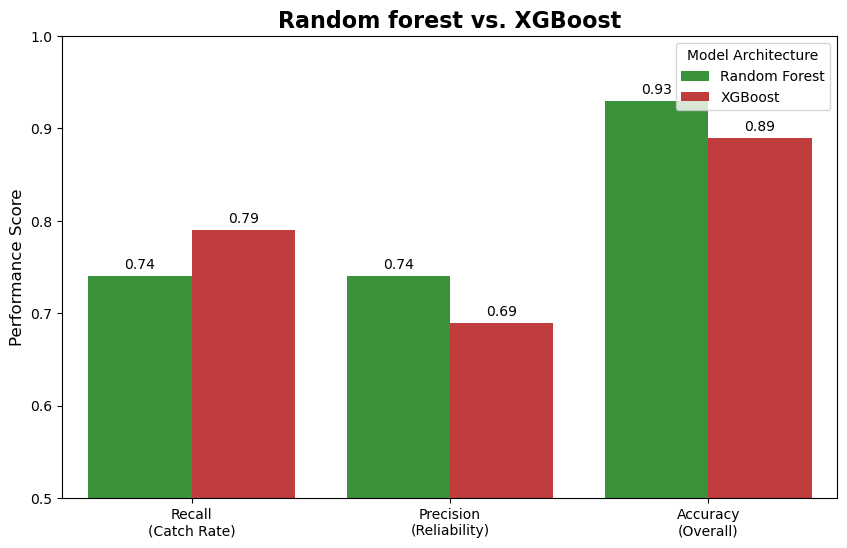

In [75]:

# Preparing Data for Visualization
# We manually construct a small dataset with the results obtained from both models
results_data = {
    'Model': ['Random Forest', 'Random Forest', 'Random Forest',
              'XGBoost', 'XGBoost', 'XGBoost'],
    'Metric': ['Recall\n(Catch Rate)', 'Precision\n(Reliability)', 'Accuracy\n(Overall)',
               'Recall\n(Catch Rate)', 'Precision\n(Reliability)', 'Accuracy\n(Overall)'],
    'Score': [0.74, 0.74, 0.93,  # Random Forest Scores
              0.79, 0.69, 0.89]  # XGBoost Scores
}

df_results = pd.DataFrame(results_data)

# Plotting the Grouped Bar Chart
plt.figure(figsize=(10, 6))

# Create barplot with hue to compare models side-by-side
ax = sns.barplot(data=df_results, x='Metric', y='Score', hue='Model', palette=['#2ca02c', '#d62728'])

# Styling and Formatting
plt.title('Random forest vs. XGBoost', fontsize=16, weight='bold')
plt.ylim(0.5, 1.0) # Focus on the upper range (50% to 100%) for better readability
plt.ylabel('Performance Score', fontsize=12)
plt.xlabel('')
plt.legend(title='Model Architecture', loc='upper right')

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.show()

**Strategic Decision Framework:**

The choice of model is not technical, but financial. It depends on the winery's specific **Cost of Error**:

| Business Scenario | Recommended Model | Financial Justification |
| :--- | :--- | :--- |
| **Ultra-Premium Strategy**<br>*(Bottle Price > $200)* | **XGBoost** | **Maximize Top-Line Revenue.** <br>The loss of missing a single $200 bottle (False Negative) outweighs the labor cost of testing false alarms. We accept lower accuracy to ensure zero "liquid gold" is discarded. |
| **Commercial Efficiency**<br>*(High Volume Production)* | **Random Forest** | **Minimize OPEX (Operating Expenses).**<br>With **93% Accuracy**, this model is far more stable. It prevents the quality control team from wasting hours on false alarms (Low Precision), ensuring the highest profit margin per hour worked. |